In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation, Conv2D, MaxPooling2D, BatchNormalization, Concatenate
from keras.layers import Reshape, MaxPooling2D, Lambda, SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
import tensorflow as tf
from keras.layers.merge import concatenate

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols, img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

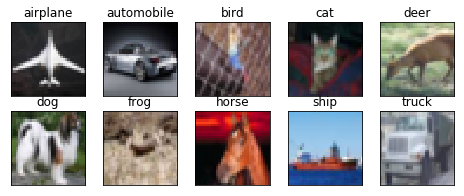

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

# Assignment 6B - Advanced Convolutions

In [8]:
# Define the model

# Model:
# Initial Convolution: Normal
# Conv(16, 3, 3, same padding, relu) + BN

#Conv Block 1
  # Spatially Separable Convolution:
  # Conv(16, 3, 1, same padding, relu) + BN
  # Conv(16, 1, 3, same padding, relu) + BN

  # Depthwise Separable Convolution
  # Conv(32, 3, 3, same padding, relu) + BN

# Transition Block 1
  # MaxPool + Conv (16, 1, 1, relu) + BN + DropOut | Output: 16
  
# Conv Block 2
  # Grouped Convolution (Kernel)
  # Conv(32, 3, 3, same padding, relu) + BN                                     Conv(32, 5, 5, same padding, relu) + BN
  # Conv(64, 3, 3, same padding, relu) + BN                                     Conv(64, 5, 5, same padding, relu) + BN
  # Concat()
  
# Transition Block 2
  # MaxPool + Conv (32, 1, 1, relu) + BN + DropOut | Output: 8

# Conv Block 3
  # Grouped Convolution (Dilation)
  # Conv(64, 3, 3, same padding, relu, dilation = 1) + BN                       Conv(64, 3, 3, same padding, relu, dilation = 1) + BN
  # Conv(128, 3, 3, same padding, relu, dilation = 2) + BN                      Conv(128, 3, 3, same padding, relu, dilation = 2) + BN
  # Concat()
  
# Transition Block 3
  # MaxPool + Conv (64, 1, 1, relu) + BN + DropOut | Output: 4
  
# Conv Block 4
# Conv(64, 3, 3, same padding, relu) + BN
# Conv(64, 3, 3, same padding, relu) + BN
  
# Final Conv
# Conv(10, 4, 4) | Output: 1

# Flatten + SoftMax
  
#------------------------------------------------------------------------------#

input = Input(shape = (img_rows, img_cols, img_channels))

# Initial Conv
layer1 = Conv2D(16, (3, 3), strides=(1,1), padding='same', activation='relu', name= 'Initial_Conv')(input)
layer1 = BatchNormalization(name= 'Initial_Conv_BN')(layer1)

# Convolution Block 1
# Spatially Separable Convolution
layer2 = Conv2D(16, (3, 1), strides=(1,1), padding='same', activation='relu', name= 'Spatial_Sep_3_1')(layer1)
layer2 = BatchNormalization(name= 'Spatial_Sep_3_1_BN')(layer2)

layer2 = Conv2D(16, (1, 3), strides=(1,1), padding='same', activation='relu', name= 'Spatial_Sep_1_3')(layer2)
layer2 = BatchNormalization(name= 'Spatial_Sep_1_3_BN')(layer2)

# Depthwise Separable Convolution
layer3 = SeparableConv2D(32, (3, 3), strides=(1,1), padding='same', activation='relu', name= 'Depth_Sep')(layer2)
layer3 = BatchNormalization(name='Depth_Sep_BN')(layer3)

# Transition Block 1
layer4 = MaxPooling2D(pool_size=(2, 2), name = 'MaxPool_1')(layer3)
layer4 = Conv2D(16, (1, 1), strides=(1,1), padding='same', activation='relu', name= 'Transition_Conv_1')(layer4)
layer4 = BatchNormalization(name= 'Transition_Conv_1_BN')(layer4)
layer4 = Dropout(0.25, name = 'Transition_Conv_1_D')(layer4)

# Convolution Block 2
# Grouped Convolution (Kernel size 3 and 5)
# Kernel 3
layer5 = Conv2D(32, (3, 3), strides=(1,1), padding='same', activation='relu', name= 'Group_3_1')(layer4)
layer5 = BatchNormalization(name= 'Group_3_1_BN')(layer5)

layer6 = Conv2D(64, (3, 3), strides=(1,1), padding='same', activation='relu', name= 'Group_3_2')(layer5)
layer6 = BatchNormalization(name= 'Group_3_2_BN')(layer6)

# Kernel 5
layer7 = Conv2D(32, (5, 5), strides=(1,1), padding='same', activation='relu', name= 'Group_5_1')(layer4)
layer7 = BatchNormalization(name= 'Group_5_1_BN')(layer7)

layer8 = Conv2D(64, (5, 5), strides=(1,1), padding='same', activation='relu', name= 'Group_5_2')(layer7)
layer8 = BatchNormalization(name= 'Group_5_2_BN')(layer7)

# Concatenation
layer9 = concatenate([layer6, layer8])

# Transition Block 2
layer10 = MaxPooling2D(pool_size=(2, 2), name = 'MaxPool_2')(layer9)
layer10 = Conv2D(32, (1, 1), strides=(1,1), padding='same', activation='relu', name= 'Transition_Conv_2')(layer10)
layer10 = BatchNormalization(name= 'Transition_Conv_2_BN')(layer10)
layer10 = Dropout(0.25, name = 'Transition_Conv_2_D')(layer10)

# Convolution Block 3
# Grouped Convolution (Dilation 1 and 2)
# Dilation = 1
layer11 = Conv2D(64, (3, 3), strides=(1,1), padding='same', dilation_rate=(1, 1), activation='relu', name= 'Group_D1_1')(layer10)
layer11 = BatchNormalization(name= 'Group_D1_1_BN')(layer11)

layer12 = Conv2D(128, (3, 3), strides=(1,1), padding='same', dilation_rate=(1, 1), activation='relu', name= 'Group_D1_2')(layer11)
layer12 = BatchNormalization(name= 'Group_D1_2_BN')(layer12)

# Dilation = 2
layer13 = Conv2D(64, (3, 3), strides=(1,1), padding='same', dilation_rate=(2, 2), activation='relu', name= 'Group_D2_1')(layer10)
layer13 = BatchNormalization(name= 'Group_D2_1_BN')(layer13)

layer14 = Conv2D(128, (3, 3), strides=(1,1), padding='same', dilation_rate=(2, 2), activation='relu', name= 'Group_D2_2')(layer13)
layer14 = BatchNormalization(name= 'Group_D2_2_BN')(layer14)

# Concatenation
layer15 = concatenate([layer12, layer14])

# Transition Block 3
layer16 = MaxPooling2D(pool_size=(2, 2), name = 'MaxPool_3')(layer15)
layer16 = Conv2D(64, (1, 1), strides=(1,1), padding='same', activation='relu', name= 'Transition_Conv_3')(layer16)
layer16 = BatchNormalization(name= 'Transition_Conv_3_BN')(layer16)
layer16 = Dropout(0.25, name = 'Transition_Conv_3_D')(layer16)

# Convolution Block 4
layer17 = Conv2D(64, (3, 3), strides=(1,1), padding='same', activation='relu', name= 'Conv_4_1')(layer16)
layer17 = BatchNormalization(name= 'Conv_4_1_BN')(layer17)

layer18 = Conv2D(64, (3, 3), strides=(1,1), padding='same', activation='relu', name= 'Conv_4_2')(layer17)
layer18 = BatchNormalization(name= 'Conv_4_2_BN')(layer18)

# Final Conv: 10 channels to bring down dimension to 1X1
layer19 = Conv2D(10, (4, 4), strides=(1,1), name= 'Final_Conv')(layer18)

# Flatten
layer20 = Flatten()(layer19)

# Output
output = Dense(num_classes, activation='softmax')(layer20)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
Initial_Conv (Conv2D)           (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
Initial_Conv_BN (BatchNormaliza (None, 32, 32, 16)   64          Initial_Conv[0][0]               
__________________________________________________________________________________________________
Spatial_Sep_3_1 (Conv2D)        (None, 32, 32, 16)   784         Initial_Conv_BN[0][0]            
__________________________________________________________________________________________________
Spatial_Se

In [0]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


Epoch 1/50
390/390 [==============================] - 36s 92ms/step - loss: 1.6785 - acc: 0.4004 - val_loss: 1.4638 - val_acc: 0.4829
Epoch 2/50
390/390 [==============================] - 26s 67ms/step - loss: 1.2737 - acc: 0.5417 - val_loss: 1.7765 - val_acc: 0.4562
Epoch 3/50
390/390 [==============================] - 25s 65ms/step - loss: 1.0757 - acc: 0.6165 - val_loss: 1.0341 - val_acc: 0.6382
Epoch 4/50
390/390 [==============================] - 25s 65ms/step - loss: 0.9330 - acc: 0.6671 - val_loss: 0.8661 - val_acc: 0.7003
Epoch 5/50
390/390 [==============================] - 25s 65ms/step - loss: 0.8376 - acc: 0.7046 - val_loss: 0.8839 - val_acc: 0.6941
Epoch 6/50
390/390 [==============================] - 25s 65ms/step - loss: 0.7597 - acc: 0.7323 - val_loss: 0.7664 - val_acc: 0.7330
Epoch 7/50
390/390 [==============================] - 18s 47ms/step - loss: 0.6969 - acc: 0.7527 - val_loss: 0.8182 - val_acc: 0.7183
Epoch 8/50
390/390 [==============================] - 13s 34ms

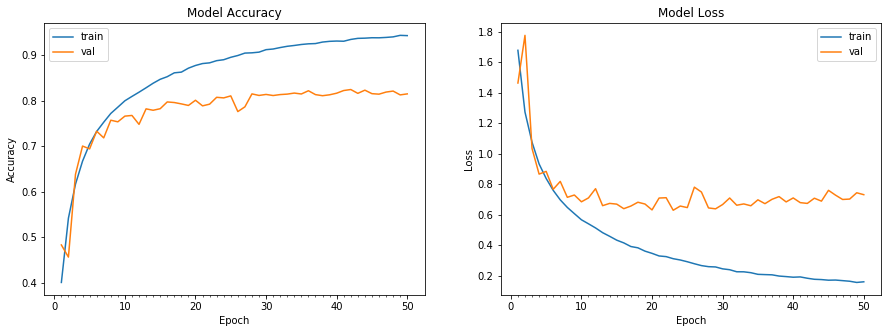

Accuracy on test data is: 81.50


In [11]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))